In [2]:
import h5py

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import numpy as np

from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d

with h5py.File('../data/posteriors_DESY3_arico.hdf5', 'r') as f:
     S8_data = f['S8'][:]
     Om_data = f['omega_matter'][:]
     sigma8_data = S8_data #* np.sqrt(.3/Om_data)

n_om = 100
n_s8 = 100
n_gamma = 100

nbins = 100

om_min = .05
om_max = 1

s8_min = 0.4
s8_max = 1.2

gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

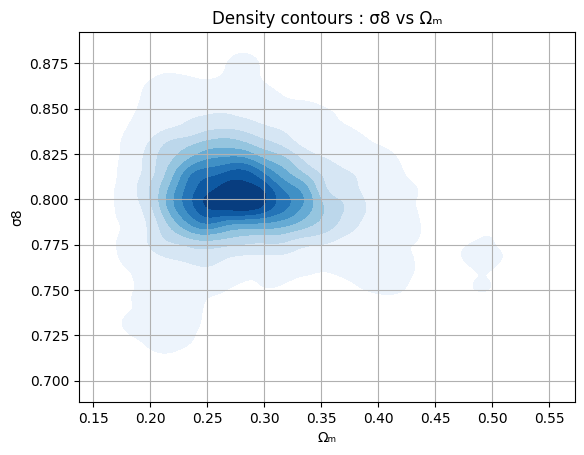

In [3]:
sns.kdeplot(x=Om_data, y=sigma8_data,
             fill=True, levels=10, cmap="Blues", thresh=0.01)

plt.xlabel("Ωₘ")
plt.ylabel("σ8")
plt.title("Density contours : σ8 vs Ωₘ")
plt.grid(True)
plt.show()

In [4]:
H, xedges, yedges = np.histogram2d(Om_data, sigma8_data, bins=nbins, range=[[om_min, om_max], [s8_min, s8_max]], density=True)
H = H.T

P = H / np.max(H)
with np.errstate(divide='ignore'):
    delta_chi2_grid_raw = -2 * np.log(P)
    delta_chi2_grid_raw[np.isinf(delta_chi2_grid_raw)] = np.nanmax(delta_chi2_grid_raw) + 1  # pour éviter les inf

In [5]:
X, Y = np.meshgrid(omega_vals, sigma_vals)
positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([Om_data, sigma8_data])
kde = gaussian_kde(values)
density = kde(positions).reshape(X.shape)

P = density / np.max(density)
with np.errstate(divide='ignore'):
    delta_chi2_grid = -2 * np.log(P)
    delta_chi2_grid[np.isinf(delta_chi2_grid)] = np.nanmax(delta_chi2_grid) + 1

In [9]:
np.savez("../output/chi2_BAO/chi2_DESY3.npz", grid=delta_chi2_grid)

<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2375/937820486.py:31: SyntaxWarning: invalid escape sequence '\D'
  display_one_chi2(delta_chi2_grid, ax[1], "Smooth $\Delta \chi^2$ contours")
/tmp/ipykernel_2375/937820486.py:32: SyntaxWarning: invalid escape sequence '\D'
  display_one_chi2(delta_chi2_grid_raw, ax[0], "Raw $\Delta \chi^2$ contours")


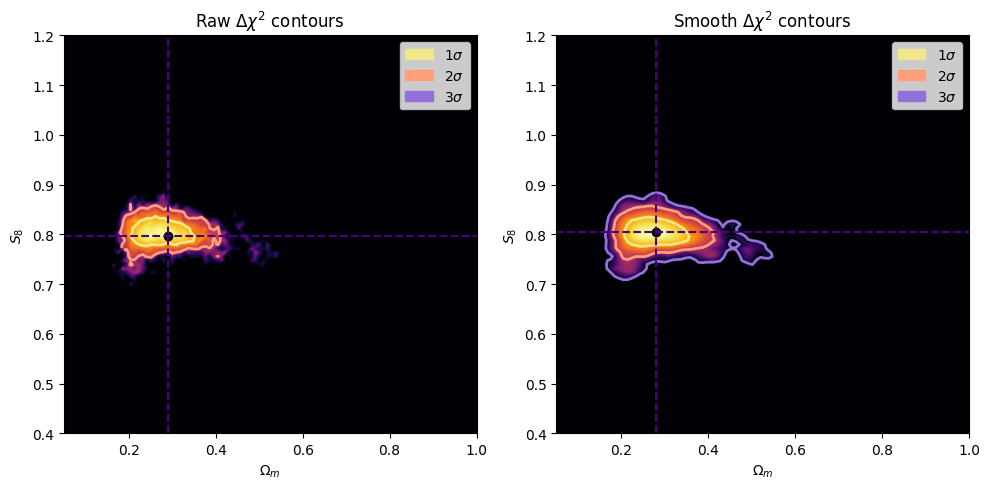

In [7]:
def display_one_chi2(chi2_grid, ax, title):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    delta_chi2_clipped = np.clip(chi2_grid, a_min=None, a_max=levels[2])
    cf = ax.contourf(omega_vals, sigma_vals, delta_chi2_clipped, levels=100, cmap='inferno_r')

    for level, color in zip(levels, colors):
        cs = ax.contour(omega_vals, sigma_vals, chi2_grid, levels=[level], colors=[color], linewidths=2)

    legend_handles = [
        Patch(color='khaki', label=r'$1\sigma$'),
        Patch(color='lightsalmon', label=r'$2\sigma$'),
        Patch(color='mediumpurple', label=r'$3\sigma$')
    ]
    ax.legend(handles=legend_handles, loc='upper right')

    min_idx = np.unravel_index(np.nanargmin(chi2_grid), chi2_grid.shape)
    x_min = omega_vals[min_idx[1]]
    y_min = sigma_vals[min_idx[0]]
    ax.plot(x_min, y_min, 'ko', label='Best-fit')
    ax.axhline(y_min, color='indigo', linestyle='--')
    ax.axvline(x_min, color='indigo', linestyle='--')

    ax.set_xlabel(r"$\Omega_m$")
    ax.set_ylabel(r"$S_8$")
    ax.set_title(title)
    ax.set_facecolor('black')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
display_one_chi2(delta_chi2_grid, ax[1], "Smooth $\Delta \chi^2$ contours")
display_one_chi2(delta_chi2_grid_raw, ax[0], "Raw $\Delta \chi^2$ contours")
plt.tight_layout()
plt.show()